# Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array,ImageDataGenerator
import json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from sklearn.model_selection import train_test_split
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model


# Dataset Generation

* Data set contain images of size 100px X 100px ,having 2 blobs of color red and blue , randomly place in the black background of the image.
* This generates 1000 images  and a csv file with images path and coordinates of each blob in the image.
* Image size, color of the image, size of the bolbs, color of the blobs , number of images - all are customisable.

(Blobs are small patches of color in the black background, of which we would predict the coordinates)

In [2]:
import cv2
import numpy as np
import pandas as pd
import random
import os

def generate_image_and_label(image_size=(100, 100)): #change the size of the image as you want
    image = np.zeros((image_size[0], image_size[1], 3), dtype=np.uint8)
    point1_color = (0, 0, 255)   # change the color as you want
    point2_color = (255, 0, 0)

    point1_coords = (random.randint(0, image_size[1]-1), random.randint(0, image_size[0]-1))
    point2_coords = (random.randint(0, image_size[1]-1), random.randint(0, image_size[0]-1))

    cv2.circle(image, point1_coords, 4, point1_color, -1) #change the radius of the blob as you want
    cv2.circle(image, point2_coords, 4, point2_color, -1)

    label = {
        'image_Name': f'image_{i+1}.png',
        'Point1_X': point1_coords[0],
        'Point1_Y': point1_coords[1],
        'Point2_X': point2_coords[0],
        'Point2_Y': point2_coords[1]
    }

    return image, label

num_images = 1000 #change the number of images as you want
output_folder = '2_blob_data'
csv_filename = 'labels.csv'

os.makedirs(output_folder, exist_ok=True)

labels_list = []

for i in range(num_images):
    image, label = generate_image_and_label()

    image_filename = f'image_{i+1}.png'
    cv2.imwrite(os.path.join(output_folder, image_filename), image)

    labels_list.append(label)

labels_df = pd.DataFrame(labels_list)
labels_df.to_csv(os.path.join(output_folder, csv_filename), index=False)

print(f'Dataset generated: {num_images} images and labels saved in {output_folder}')


Dataset generated: 1000 images and labels saved in 2_blob_data


# csv file

In [3]:
path = '2_blob_data'
df = pd.read_csv(os.path.join(path,'labels.csv'))
df.head()

,image_Name,Point1_X,Point1_Y,Point2_X,Point2_Y
0,image_1.png,14,86,76,42
1,image_2.png,71,56,88,54
2,image_3.png,58,55,56,99
3,image_4.png,46,68,96,97
4,image_5.png,33,85,38,42


# Image preprocessing

* Load the image and change to the target size
* Convert the image to array
* Noramlize the image px values by dividing by 255

In [51]:
df_name = df['image_Name']
imgs = []
def load_and_preprocess_image(image_path,target_size=(100,100)):
    img = load_img(image_path,target_size=target_size, color_mode='rgb')
    img_array = img_to_array(img) / 255.0
    img_array = img_array.reshape((1,) + img_array.shape)
    return img_array

for i in range(len(df_name)):
    image_path = os.path.join(path,df_name[i])
    img_array = load_and_preprocess_image(image_path)
    imgs.append(img_array)

imgs = np.vstack(imgs)
imgs.shape

(1000, 100, 100, 3)

In [52]:
labels = df[['Point1_X','Point1_Y','Point2_X','Point2_Y']].values
labels.shape

(1000, 4)

# Train - Validation split

* Split in the ration 9:1 , i.e 900 train images and 100 validation images

In [53]:
X_train, X_val, y_train, y_val = train_test_split(imgs, labels, test_size=0.1, random_state=42)

# CNN

* Conv-layer -> Maxpooling -> Dropout , these layers are implemented 3 times
* followed by Flattening and producing final 4 outputs

In [119]:
model = Sequential([
    Conv2D(filters=64,kernel_size= (3, 3), activation='relu', padding='same',input_shape=(100, 100, 3)),
    # BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),
    # Conv2D(filters=64,kernel_size= (3, 3), activation='relu', padding='same'),
    # # BatchNormalization(),
    # MaxPooling2D((2, 2)),
    # Dropout(0.1),
    Conv2D(128, (2, 2),  padding='same',activation='relu'),
    # BatchNormalization(),
    MaxPooling2D((1, 1)),
    Dropout(0.1),
    Conv2D(256, (2, 2), padding='same', activation='relu'),
    MaxPooling2D((1, 1)),
    Dropout(0.1),

    Flatten(),
    Dense(256, activation='relu'),
    Dense(4)
])

early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                 patience=10,
                                 restore_best_weights=True)
reduce_learning=tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss',
                                     factor=0.2,
                                     verbose=0,
                                     patience=5,
                                     min_lr=0.000001,
)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_29 (Conv2D)                   │ (None, 100, 100, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 50, 50, 128)         │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 50, 50, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 50, 50, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 50, 50, 256)         │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 50, 50, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 50, 50, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 640000)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 256)                 │     163,840,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 164,007,300 (625.64 MB)

 Trainable params: 164,007,300 (625.64 MB)

 Non-trainable params: 0 (0.00 B)

In [120]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_learning],
    verbose=1
)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 253ms/step - loss: 1644.9176 - mae: 32.6302 - val_loss: 528.9154 - val_mae: 18.5400 - learning_rate: 0.0010
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 360.6760 - mae: 14.8739 - val_loss: 119.3342 - val_mae: 8.3153 - learning_rate: 0.0010
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 73.6662 - mae: 6.4953 - val_loss: 76.6610 - val_mae: 6.0357 - learning_rate: 0.0010
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 30.3686 - mae: 4.0956 - val_loss: 55.9719 - val_mae: 5.0164 - learning_rate: 0.0010
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 18.8908 - mae: 3.2390 - val_loss: 51.7672 - val_mae: 4.7971 - learning_rate: 0.0010
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 12.1054 - mae: 2.6083 - val_loss: 48.3689 - val_mae: 4.5198 - learning_rate: 0.0010
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 9.9983 - mae: 2.3458 - val_loss: 38.3991 - val_mae: 4.1300 - learning_ra

# Train Vs Validation loss

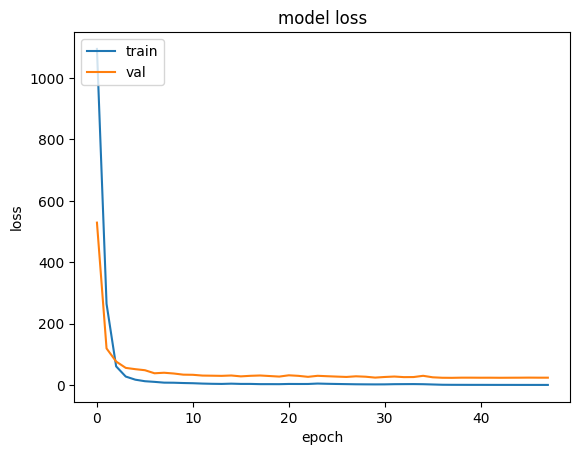

In [121]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')



### Last 15 training epoch , to show that the training hasn't plateaued , but close to plateauing

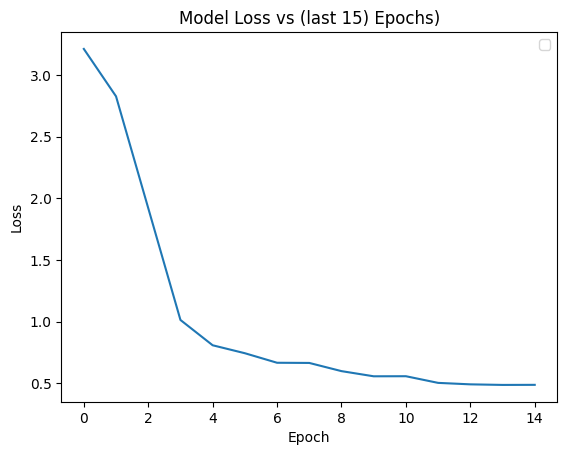

In [127]:
plt.plot(history.history['loss'][-15:])
plt.title('Model Loss vs (last 15) Epochs)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Testing the Model

* generate a new images , preprocess and give to the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


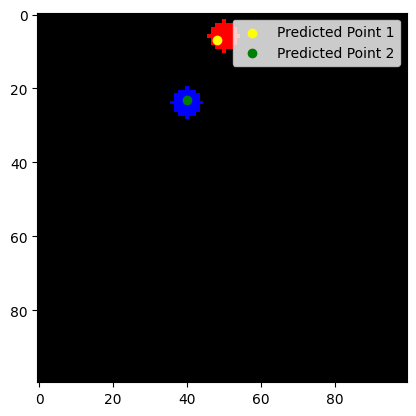

In [128]:
image,label = generate_image_and_label()
import tempfile
with tempfile.NamedTemporaryFile(suffix=".png", delete=True) as tmpfile:
    image_path = tmpfile.name
    cv2.imwrite(image_path, image)

    image = load_and_preprocess_image(image_path)

predicted_points = model.predict(image)

image_display = image[0] * 255
image_display = image_display.astype('uint8')

p1_x = int(predicted_points[0][0])
p1_y = int(predicted_points[0][1])
p2_x = int(predicted_points[0][2])
p2_y = int(predicted_points[0][3])


plt.imshow(image_display)
plt.scatter(p1_x, p1_y, color='yellow', label='Predicted Point 1')
plt.scatter(p2_x, p2_y, color='green', label='Predicted Point 2')

plt.legend()
plt.show()

* Image of the prediction on the actual image
* Error calculated as :  $   
\text{Error (%)} = \left( \frac{\text{Absolute Difference}}{\text{Actual Value}} \right) \times 100
$


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


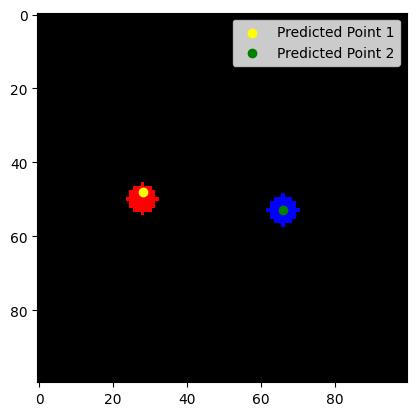

Predicted Points: [28, 48, 66, 53]
Actual Label: [28, 50, 66, 53]
Error Point 1 X: 0.00 %
Error Point 1 Y: 4.00 %
Error Point 2 X: 0.00 %
Error Point 2 Y: 0.00 %


In [133]:
image,label = generate_image_and_label()
import tempfile
with tempfile.NamedTemporaryFile(suffix=".png", delete=True) as tmpfile:
    image_path = tmpfile.name
    cv2.imwrite(image_path, image)

    image = load_and_preprocess_image(image_path)

predicted_points = model.predict(image)

image_display = image[0] * 255
image_display = image_display.astype('uint8')

p1_x = int(predicted_points[0][0])
p1_y = int(predicted_points[0][1])
p2_x = int(predicted_points[0][2])
p2_y = int(predicted_points[0][3])


plt.imshow(image_display)
plt.scatter(p1_x, p1_y, color='yellow', label='Predicted Point 1')
plt.scatter(p2_x, p2_y, color='green', label='Predicted Point 2')

plt.legend()
plt.show()

predicted_points = [p1_x, p1_y, p2_x, p2_y]

actual_points = [label["Point1_X"], label["Point1_Y"], label["Point2_X"], label["Point2_Y"]]

print("Predicted Points:", predicted_points)
print("Actual Label:", actual_points)

diff_p1x = np.abs(p1_x - label["Point1_X"])
diff_p1y = np.abs(p1_y - label["Point1_Y"])
diff_p2x = np.abs(p2_x - label["Point2_X"])
diff_p2y = np.abs(p2_y - label["Point2_Y"])

epsilon = 1e-7
relative_diff_p1x = diff_p1x / (label["Point1_X"] + epsilon)
relative_diff_p1y = diff_p1y / (label["Point1_Y"] + epsilon)
relative_diff_p2x = diff_p2x / (label["Point2_X"] + epsilon)
relative_diff_p2y = diff_p2y / (label["Point2_Y"] + epsilon)

print(f"Error Point 1 X: {relative_diff_p1x*100 :.2f} %")
print(f"Error Point 1 Y: {relative_diff_p1y*100 :.2f} %")
print(f"Error Point 2 X: {relative_diff_p2x*100 :.2f} %")
print(f"Error Point 2 Y: {relative_diff_p2y*100 :.2f} %")